# Calculating a rider's CoM position from Retul Vantage data
_**Copyright (C) Ross Wilkinson 2021**_ - vantage_com.ipynb by Ross Duncan Wilkinson is licensed under a Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License.

## Background
Determining the human body's center of mass is an important tool for analysing the biomechanics and energetics of human motion. In a biomechanical research setting, the most accurate estimates of each segment's CoM position requires placing and tracking the three-dimensional position of more than 38 markers (Tisserand et al., 2016). This method is expensive and time consuming, which is impractical for certain applications like bike fitting. Therefore another approach is to use a reduced number of markers to estimate whole body CoM position (Dumas & Wojtusch, 2017). In either case, the technique involves determining the end points of each segment and estimates of body segment inertial parameters (BSIPs). BSIPs include BSIPs can be obtained in different ways including direct measurements on cadavers or photogrammetry and medical imaging on living humans, but they are more generally estimated by regression equations (based on those measurements).

The following approach uses BSIPs based on the regression equations of De Leva (1996) adjusted from the data of Zatsiorsky et al. (1990) in combination with Retul Vantage data (8 markers) to estimate the whole-body CoM position of a 16-segment rigid body biomechanical model (head with neck, upper trunk, middle trunk, lower trunk, upper arm (x2), forearm (x2), hand (x2), thigh (x2), shank (x2), and foot (x2).

Beyond the limitations inherent to estimating BSIPs, the main assumptions for this approach are:
* Retul Vantage marker placements correspond to segment end-points
* Motion of the right and left limbs are symmetrical
* The length of each subject's "head with neck" segment is the same within each sex
* The alignment of the "head with neck" segment changes as a function of upper-trunk angle
* The length of each hand is 0 mm
* The length of each foot is from the calcaneus to the MTP joint
 
**References**
* de Leva, P. (1996). Adjustments to Zatsiorsky-Seluyanov's segment inertia parameters. _Journal of Biomechanics_, _29_(9), 1223-1230. <https://doi.org/10.1016/0021-9290(95)00178-6>
* Tisserand, R., Robert, T., Dumas, R., & Chèze, L. (2016). A simplified marker set to define the center of mass for stability analysis in dynamic situations. _Gait and Posture_, _48_, 64-67. <https://doi.org/10.1016/j.gaitpost.2016.04.032>
* Dumas, R., & Wojtusch, J. (2017). Estimation of the Body Segment Inertial Parameters for the Rigid Body Biomechanical Models Used in Motion Analysis. In _Handbook of Human Motion_. <https://doi.org/10.1007/978-3-319-30808-1>

## Import libraries

In [92]:
# from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from scipy.signal import find_peaks

## Define functions
* parse_pose_file
* perpendicular
* get_circle
* vantage_com

In [7]:
def parse_pose_file(pathToPoseFile):
    tree = ET.parse(pathToPoseFile)
    root = tree.getroot()

    foot = []
    heel = []
    ankle = []
    knee = []
    hip = []
    shoulder = []
    elbow = []
    wrist = []

    for child in root:
        if child.tag == 'title':
            title = child.text
        if child.tag == 'dateTime':
            date = child.text
        if child.tag == 'upward':
            upward = child.text.split(" ")
        if child.tag == 'forward':
            forward = child.text.split(" ")
        if child.tag == 'viewedSide':
            side = child.text.split(" ")
        if child.tag == 'psoX':
            pso_x = child.text.split(" ")
        if child.tag == 'psoZ':
            pso_y = child.text.split(" ")

    for frame in root.findall("./stxyz"):
        if frame.tag == 'stxyz':
            for point in frame:
                if point.tag == 'ft':
                    foot.append(point.text.split(" "))
                elif point.tag == 'he':
                    heel.append(point.text.split(" "))
                elif point.tag == 'an':
                    ankle.append(point.text.split(" "))
                elif point.tag == 'kn':
                    knee.append(point.text.split(" "))
                elif point.tag == 'hp':
                    hip.append(point.text.split(" "))
                elif point.tag == 'sh':
                    shoulder.append(point.text.split(" "))
                elif point.tag == 'el':
                    elbow.append(point.text.split(" "))
                elif point.tag == 'wr':
                    wrist.append(point.text.split(" "))

    footDF = pd.DataFrame(foot, columns=['foot_status', 'foot_time', 'foot_x_pos', 'foot_y_pos', 'foot_z_pos'])    
    heelDF = pd.DataFrame(heel, columns=['heel_status', 'heel_time', 'heel_x_pos', 'heel_y_pos', 'heel_z_pos'])
    ankleDF = pd.DataFrame(ankle, columns=['ankle_status', 'ankle_time', 'ankle_x_pos', 'ankle_y_pos', 'ankle_z_pos'])
    kneeDF = pd.DataFrame(knee, columns=['knee_status', 'knee_time', 'knee_x_pos', 'knee_y_pos', 'knee_z_pos'])
    hipDF = pd.DataFrame(hip, columns=['hip_status', 'hip_time', 'hip_x_pos', 'hip_y_pos', 'hip_z_pos'])
    shoulderDF = pd.DataFrame(shoulder, columns=['shoulder_status', 'shoulder_time', 'shoulder_x_pos', 'shoulder_y_pos', 'shoulder_z_pos'])
    elbowDF = pd.DataFrame(elbow, columns=['elbow_status', 'elbow_time', 'elbow_x_pos', 'elbow_y_pos', 'elbow_z_pos'])
    wristDF = pd.DataFrame(wrist, columns=['wrist_status', 'wrist_time', 'wrist_x_pos', 'wrist_y_pos', 'wrist_z_pos'])
    poseDF = pd.concat([footDF, heelDF, ankleDF, kneeDF, hipDF, shoulderDF, elbowDF, wristDF], axis=1)

    columns_to_convert_numeric = ['foot_time', 'foot_x_pos', 'foot_y_pos', 'foot_z_pos',
                                  'heel_time', 'heel_x_pos', 'heel_y_pos', 'heel_z_pos',
                                  'ankle_time', 'ankle_x_pos', 'ankle_y_pos', 'ankle_z_pos',
                                  'knee_time', 'knee_x_pos', 'knee_y_pos', 'knee_z_pos',
                                  'hip_time', 'hip_x_pos', 'hip_y_pos', 'hip_z_pos',
                                  'shoulder_time', 'shoulder_x_pos', 'shoulder_y_pos', 'shoulder_z_pos',
                                  'elbow_time', 'elbow_x_pos', 'elbow_y_pos', 'elbow_z_pos',
                                  'wrist_time', 'wrist_x_pos', 'wrist_y_pos', 'wrist_z_pos']
    poseDF[columns_to_convert_numeric] = poseDF[columns_to_convert_numeric].apply(pd.to_numeric)

    pose_dict = {'title': title, 'date': date, 'upward': upward, 'forward': forward, 'side': side, 'pso_x': float(pso_x[0]), 'pso_y': float(pso_y[0]), '3d_cord_DF': poseDF}

    return pose_dict

In [54]:
def perpendicular( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

In [55]:
def get_circle(x, y):
    # https://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html

    method_1 = 'algebraic'

    # coordinates of the barycenter
    x_m = np.mean(x)
    y_m = np.mean(y)

    # calculation of the reduced coordinates
    u = x - x_m
    v = y - y_m

    # linear system defining the center (uc, vc) in reduced coordinates:
    #    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
    #    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
    Suv  = sum(u*v)
    Suu  = sum(u**2)
    Svv  = sum(v**2)
    Suuv = sum(u**2 * v)
    Suvv = sum(u * v**2)
    Suuu = sum(u**3)
    Svvv = sum(v**3)

    # Solving the linear system
    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = np.linalg.solve(A, B)

    xc_1 = x_m + uc
    yc_1 = y_m + vc

    # Calcul des distances au centre (xc_1, yc_1)
    Ri_1     = np.sqrt((x-xc_1)**2 + (y-yc_1)**2)
    R_1      = np.mean(Ri_1)
    residu_1 = sum((Ri_1-R_1)**2)

    return xc_1, yc_1, R_1, residu_1

In [148]:
def vantage_com(**kwargs):
  '''
  VANTAGE_COM Calculates a cyclist's center of mass position from the Retul 
  Vantage motion capture output file (.pose).

  Parameters
  ----------
  file : STR
    The .pose file name. Needs to exist in current directory.

  sex : STR
    Sex of the rider as 'male' or 'female' (default : 'male')
  
  mass : FLOAT
    Mass of rider in kilograms (default male : 78.05, default female : 64.26)

  sacralAngle : FLOAT
    Angle of sacrum in degrees counter-clockwise from horizontal (default : 54.0)

  shoulderWidth : FLOAT
    Width of shoulders in millimeters (default male : 411.0, default female : 367.0)

  hipWidth : FLOAT
    Width of hips in millimeters (default male : 296.0, default female : 291)

  shoeMass : FLOAT
    Mass of each shoe in kilograms (default : 1)

  Returns
  -------
  com3d : NP.ARRAY (m,3)
    Array (m,3) of 3-D center of mass position within the Vantage CS.
    Upsampled to 200 Hz.

  com2bb : NP.ARRAY (m,1)
    Array (m,1) of fore-aft CoM position relative to the bicycle bottom bracket.
    Upsampled to 200 Hz.
  
  com2bbMean : FLOAT
    Mean value of com2bb.

  Examples
  --------
  com3d = vantage_com()

  vantage_com(file='foo.pose')

  vantage_com(file='foo.pose', shoeMass = 0.5, sex = 'female', mass = 58.0)
  '''
  
  ### Evaluate inputs and initialize defaults if needed
  if not kwargs.get('file'):
    raise ValueError('Please specify a .pose file in the current directory')
  
  if not kwargs.get('sex'):
    kwargs.setdefault('sex','male')
  
  if not kwargs.get('mass'):
    if kwargs.get('sex') == 'male':
      kwargs.setdefault('mass',78.05)
    else:
      kwargs.setdefault('mass',78.05)

  if not kwargs.get('sacralAngle'):
    kwargs.setdefault('sacralAngle',54.0)

  if not kwargs.get('shoulderWidth'):
    if kwargs.get('sex') == 'male':
      kwargs.setdefault('shoulderWidth',411.0)
    else:
      kwargs.setdefault('shoulderWidth',367.0)

  if not kwargs.get('hipWidth'):
    if kwargs.get('sex') == 'male':
      kwargs.setdefault('hipWidth',296.0)
    else:
      kwargs.setdefault('hipWidth',291.0)

  if not kwargs.get('shoeMass'):
    kwargs.setdefault('shoeMass', 1.0)

  ### Call parse_pose_file function
  dataPose = parse_pose_file(kwargs.get('file'))

  ### Set Body Segment Inertial Parameters (BSIPs)
  '''
  Briefly, the segment mass is computed as a percentage of the body mass. 
  The position of the segment's CoM is computed as a percentage of the 
  segment length, defined as the distance between the segment end-points.
  '''
  nSegments = 16

  if kwargs.get('sex') == 'male':
    # Mass (% of whole body)
    M = np.array([
                  0.0694,   # head
                  0.1596,   # upper trunk
                  0.1633,   # middle trunk
                  0.1117,   # lower trunk
                  0.0271,   # upper arm right
                  0.0162,   # forearm right
                  0.0061,   # hand right
                  0.1416,   # thigh right
                  0.0433,   # shank right
                  0.0137,   # foot right
                  0.0271,   # upper arm left
                  0.0162,   # forearm left
                  0.0061,   # hand left
                  0.1416,   # thigh left
                  0.0433,   # shank left
                  0.0137    # foot left
    ]).reshape(16,1)
    # Length to segment CoM (% from proximal end-point)
    L = np.array([
                  0.5002,   # head
                  0.2999,   # upper trunk
                  0.4502,   # middle trunk
                  0.6115,   # lower trunk
                  0.5772,   # upper arm right
                  0.4608,   # forearm right
                  0.7948,   # hand right
                  0.4095,   # thigh right
                  0.4459,   # shank right
                  0.4415,   # foot right
                  0.5772,   # upper arm left
                  0.4608,   # forearm left
                  0.7948,   # hand left
                  0.4095,   # thigh left
                  0.4459,   # shank left
                  0.4415    # foot left  
    ]).reshape(16,1)
  elif kwargs.get('sex') == 'female':
    # Mass (% of whole body)
    M = np.array([
                  0.0668,   # head
                  0.1545,   # upper trunk
                  0.1465,   # middle trunk
                  0.1247,   # lower trunk
                  0.0255,   # upper arm right
                  0.0138,   # forearm right
                  0.0056,   # hand right
                  0.1478,   # thigh right
                  0.0481,   # shank right
                  0.0129,   # foot right
                  0.0255,   # upper arm left
                  0.0138,   # forearm left
                  0.0056,   # hand left
                  0.1478,   # thigh left
                  0.0481,   # shank left
                  0.0129,   # foot left
    ]).reshape(16,1)
    # Length to segment CoM (% from proximal end-point)
    L = np.array([
                  0.4841,   # head
                  0.2077,   # upper trunk
                  0.4512,   # middle trunk
                  0.4920,   # lower trunk
                  0.5754,   # upper arm right
                  0.4592,   # forearm right
                  0.7534,   # hand right
                  0.3612,   # thigh right
                  0.4416,   # shank right
                  0.4014,   # foot right
                  0.5754,   # upper arm left
                  0.4559,   # forearm left
                  0.7474,   # hand left
                  0.3612,   # thigh left
                  0.4416,   # shank left
                  0.4014    # foot left
    ]).reshape(16,1)

  ### Add shoe mass to each foot
  relativeShoeMass = kwargs.get('shoeMass') / kwargs.get('mass')
  M = M - (relativeShoeMass / nSegments)
  M[9] = M[9] + relativeShoeMass
  M[15] = M[9]

  ### Upsample and synchronize time-series data
  '''
  Vantage markers are initialized asynchronously. Upsampling the data from 
  18 Hz to 200 Hz decreases the absolute time delay in initialization
  between markers. The wrist marker is initialized last. Therefore, clip all 
  other marker signals collected prior to the first frame of the wrist marker.
  '''
  markerList = ['foot','heel','ankle','knee','hip','shoulder','elbow','wrist']
  nMarkers = len(markerList)
  df = dataPose.get('3d_cord_DF').copy()
  nFrames = len(df)

  # Create new sample points based on when wrist marker is initialized
  tTot = df['foot_time'].max() - df['wrist_time'].min()
  nSamples = int(tTot * 200)
  xVals = np.linspace(df['wrist_time'].min(), df['foot_time'].max(), nSamples)

  d = {}
  for i in range(nMarkers):
    marker = markerList[i]
    t = df[marker + '_time']
    y = t
    yInterp = np.interp(xVals,t,y)
    d[marker + '_time'] = yInterp
    y = df[marker + '_x_pos']
    yInterp = np.interp(xVals,t,y)
    d[marker + '_x_pos'] = yInterp
    y = df[marker + '_y_pos']
    yInterp = np.interp(xVals,t,y)
    d[marker + '_y_pos'] = yInterp
    y = df[marker + '_z_pos']
    yInterp = np.interp(xVals,t,y)
    d[marker + '_z_pos'] = yInterp

  ### Create out-of-phase contralateral markers
  '''
  Phase-shift ipsilateral markers by finding the half-cycle period of the
  x-coordinate of the meta-tarsal marker ("ft") signal. This should be a
  good estimate of the time taken to complete a half crank cycle.
  '''
  # Find peaks in signal
  peaks,_ = find_peaks(d['foot_x_pos'],distance = 60)

  # Calculate phase shift as half width of wavelength
  waveLength = 0
  for i in range(0,len(peaks)-1):
    waveLength += peaks[i+1] - peaks[i]

  waveLengthMean = waveLength / (len(peaks)-1)
  phaseShift = int(waveLengthMean/2)

  for i in range(nMarkers):
    marker = markerList[i]
    signalTime = d[marker + '_time']
    signalX = d[marker + '_x_pos']
    signalY = d[marker + '_y_pos']
    signalZ = d[marker + '_z_pos']
    if dataPose['side'] == ['R']:
      d[marker + '_time'] = signalTime[0:len(signalX)-phaseShift]
      d[marker + '_R_x_pos'] = signalX[0:len(signalX)-phaseShift]
      d[marker + '_x_pos'] = signalX[phaseShift-1:-1]
      d[marker + '_R_y_pos'] = signalY[0:len(signalY)-phaseShift]
      d[marker + '_y_pos'] = signalY[phaseShift-1:-1]
      d[marker + '_R_z_pos'] = signalZ[0:len(signalZ)-phaseShift]
      d[marker + '_z_pos'] = signalZ[phaseShift-1:-1]
    elif dataPose['side'] == ['L']:
      d[marker + '_time'] = signalTime[0:len(signalX)-phaseShift]
      d[marker + '_R_x_pos'] = signalX[phaseShift-1:-1]
      d[marker + '_x_pos'] = signalX[0:len(signalX)-phaseShift]
      d[marker + '_R_y_pos'] = signalY[phaseShift-1:-1]
      d[marker + '_y_pos'] = signalY[0:len(signalY)-phaseShift]
      d[marker + '_R_z_pos'] = signalZ[phaseShift-1:-1]
      d[marker + '_z_pos'] = signalZ[0:len(signalZ)-phaseShift]

  df200Hz = pd.DataFrame(d)
  nSamples = len(df200Hz)

  ### Create estimate of lower trunk length
  '''
  Estimate trunk length as the euclidean distance between shoulder and hip XY 
  position. Use BSIPs from De Leva (1996) for the distribution of trunk length.
  '''
  trunkLength = []
  for i in range(nSamples):
    shoulderXy = np.array((df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_y_pos'][i]))
    hipXy = np.array((df200Hz['hip_x_pos'][i], df200Hz['hip_y_pos'][i]))
    trunkLength.append(np.linalg.norm(shoulderXy-hipXy))
  
  trunkLength = np.array(trunkLength)
  
  if kwargs.get('sex') == 'male':
    lowerTrunkLength = trunkLength * (145.7 / 531.9)
  elif kwargs.get('sex') == 'female':
    lowerTrunkLength = trunkLength * (181.5 / 529.9)
  
  ### Create virtual marker at proximal endpoint of lower trunk
  lowerTrunkLengthX = np.cos(np.deg2rad(kwargs.get('sacralAngle'))) * lowerTrunkLength
  lowerTrunkLengthY = np.sin(np.deg2rad(kwargs.get('sacralAngle'))) * lowerTrunkLength

  if dataPose['side'] == ['R']:
    df200Hz['lowerTrunk_x_pos'] = df200Hz['hip_R_x_pos'] - lowerTrunkLengthX
    df200Hz['lowerTrunk_y_pos'] = df200Hz['hip_R_y_pos'] - lowerTrunkLengthY
    df200Hz['lowerTrunk_z_pos'] = df200Hz['hip_R_z_pos']
  elif dataPose['side'] == ['L']:
    df200Hz['lowerTrunk_x_pos'] = df200Hz['hip_x_pos'] + lowerTrunkLengthX
    df200Hz['lowerTrunk_y_pos'] = df200Hz['hip_y_pos'] - lowerTrunkLengthY
    df200Hz['lowerTrunk_z_pos'] = df200Hz['hip_z_pos'] - lowerTrunkLengthY
  
  ### Create estimate of head and middle trunk
  '''
  Use BSIPs from De Leva (1996) to estimate head length. Estimate middle trunk 
  length as a portion of the residual length from lower trunk marker to shoulder.
  '''
  residualTrunkLength = []
  residualTrunkAngle = []
  for i in range(nSamples):
    shoulderXy = np.array((df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_y_pos'][i]))
    lowerTrunkXy = np.array((df200Hz['lowerTrunk_x_pos'][i], df200Hz['lowerTrunk_y_pos'][i]))
    residualTrunkLength.append(np.linalg.norm(shoulderXy-lowerTrunkXy))
    residualTrunkAngle.append(np.arctan((shoulderXy[1] - shoulderXy[1]) / (shoulderXy[0]-lowerTrunkXy[0])))

  residualTrunkLength = np.array(residualTrunkLength)
  residualTrunkAngle = np.array(residualTrunkAngle)

  if kwargs.get('sex') == 'male':
    headLength = 242.9
    middleTrunkLength = residualTrunkLength * (215.5 / (170.7 + 215.5))
  elif kwargs.get('sex') == 'female':
    headLength = 243.7
    middleTrunkLength = residualTrunkLength * (205.3 / (142.5 + 205.3))

  ### Estimate head angle based on residual trunk angle
  '''
  Linear function of residual trunk angle. Predicting that the head angle
  moves from 55 to 80 deg. relative to horizontal as the trunk moves from 0
  to 90 deg. (vertical).
  '''
  if dataPose['side'] == ['R']:
    headAngle = 0.5 * residualTrunkAngle + 0.95993
  elif dataPose['side'] == ['L']:
    headAngle = 0.2778 * residualTrunkAngle + 1.309
  
  ### Create virtual markers at the proximal end of the head and middle trunk
  '''
  Estimate the position of vertex of head by adding head length to shoulder
  position and using residual trunk angle. Estimate the position of the
  proximal end of the middle trunk by adding middle trunk length to lower
  trunk marker at residual trunk angle.
  '''
  middleTrunkLengthX = np.cos(residualTrunkAngle) * middleTrunkLength
  middleTrunkLengthY = np.sin(residualTrunkAngle) * middleTrunkLength
  headLengthX = np.cos(headAngle) * headLength
  headLengthY = np.sin(headAngle) * headLength

  if dataPose['side'] == ['R']:
    df200Hz['head_x_pos'] = df200Hz['shoulder_R_x_pos'] - headLengthX
    df200Hz['head_y_pos'] = df200Hz['shoulder_R_y_pos'] - headLengthY
    df200Hz['head_z_pos'] = df200Hz['shoulder_R_z_pos']
    df200Hz['middleTrunk_x_pos'] = df200Hz['lowerTrunk_x_pos'] - middleTrunkLengthX
    df200Hz['middleTrunk_y_pos'] = df200Hz['lowerTrunk_y_pos'] - middleTrunkLengthY
    df200Hz['middleTrunk_z_pos'] = df200Hz['lowerTrunk_z_pos']
  elif dataPose['side'] == ['L']:
    df200Hz['head_x_pos'] = df200Hz['shoulder_x_pos'] + headLengthX
    df200Hz['head_y_pos'] = df200Hz['shoulder_y_pos'] - headLengthY
    df200Hz['head_z_pos'] = df200Hz['shoulder_z_pos']
    df200Hz['middleTrunk_x_pos'] = df200Hz['lowerTrunk_x_pos'] + middleTrunkLengthX
    df200Hz['middleTrunk_y_pos'] = df200Hz['lowerTrunk_y_pos'] - middleTrunkLengthY
    df200Hz['middleTrunk_z_pos'] = df200Hz['lowerTrunk_z_pos']
  
  ### Adjust Z coordinates of contralateral markers
  '''
  If custom shoulder or hip width measurements are not provided then defaults
  are taken from the CDC data 
  (<https://www.cdc.gov/nchs/data/series/sr_11/sr11_249.pdf>) for average
  shoulder and hip breadth for males and females.
  '''
  if dataPose['side'] == ['R']:
    df200Hz['head_z_pos'] = df200Hz['head_z_pos'] - (kwargs.get('shoulderWidth') / 2)
    df200Hz['middleTrunk_z_pos'] = df200Hz['middleTrunk_z_pos'] - (kwargs.get('hipWidth') / 2)
    df200Hz['lowerTrunk_z_pos'] = df200Hz['lowerTrunk_z_pos'] - (kwargs.get('hipWidth') / 2)
    df200Hz['shoulder_z_pos'] = df200Hz['shoulder_R_z_pos'] - kwargs.get('shoulderWidth')
    df200Hz['elbow_z_pos'] = df200Hz['shoulder_R_z_pos'] - kwargs.get('shoulderWidth') - (df200Hz['elbow_R_z_pos'] - df200Hz['shoulder_R_z_pos'])
    df200Hz['wrist_z_pos'] = df200Hz['shoulder_R_z_pos'] - kwargs.get('shoulderWidth') - (df200Hz['wrist_R_z_pos'] - df200Hz['shoulder_R_z_pos'])
    df200Hz['hip_z_pos'] = df200Hz['hip_R_z_pos'] - kwargs.get('hipWidth')
    df200Hz['knee_z_pos'] = df200Hz['hip_R_z_pos'] - kwargs.get('hipWidth') - (df200Hz['knee_R_z_pos'] - df200Hz['hip_R_z_pos'])
    df200Hz['ankle_z_pos'] = df200Hz['hip_R_z_pos'] - kwargs.get('hipWidth') - (df200Hz['ankle_R_z_pos'] - df200Hz['hip_R_z_pos'])
    df200Hz['heel_z_pos'] = df200Hz['hip_R_z_pos'] - kwargs.get('hipWidth') - (df200Hz['heel_R_z_pos'] - df200Hz['hip_R_z_pos'])  
    df200Hz['foot_z_pos'] = df200Hz['hip_R_z_pos'] - kwargs.get('hipWidth') - (df200Hz['foot_R_z_pos'] - df200Hz['hip_R_z_pos'])
  elif dataPose['side'] == ['L']:
    df200Hz['head_z_pos'] = df200Hz['head_z_pos'] - (kwargs.get('shoulderWidth') / 2)
    df200Hz['middleTrunk_z_pos'] = df200Hz['middleTrunk_z_pos'] - (kwargs.get('hipWidth') / 2)
    df200Hz['lowerTrunk_z_pos'] = df200Hz['lowerTrunk_z_pos'] - (kwargs.get('hipWidth') / 2)
    df200Hz['shoulder_R_z_pos'] = df200Hz['shoulder_z_pos'] - kwargs.get('shoulderWidth')
    df200Hz['elbow_R_z_pos'] = df200Hz['shoulder_z_pos'] - kwargs.get('shoulderWidth') - (df200Hz['elbow_z_pos'] - df200Hz['shoulder_z_pos'])
    df200Hz['wrist_R_z_pos'] = df200Hz['shoulder_z_pos'] - kwargs.get('shoulderWidth') - (df200Hz['wrist_z_pos'] - df200Hz['shoulder_z_pos'])
    df200Hz['hip_R_z_pos'] = df200Hz['hip_z_pos'] - kwargs.get('hipWidth')
    df200Hz['knee_R_z_pos'] = df200Hz['hip_z_pos'] - kwargs.get('hipWidth') - (df200Hz['knee_z_pos'] - df200Hz['hip_z_pos'])
    df200Hz['ankle_R_z_pos'] = df200Hz['hip_z_pos'] - kwargs.get('hipWidth') - (df200Hz['ankle_z_pos'] - df200Hz['hip_z_pos'])
    df200Hz['heel_R_z_pos'] = df200Hz['hip_z_pos'] - kwargs.get('hipWidth') - (df200Hz['heel_z_pos'] - df200Hz['hip_z_pos'])  
    df200Hz['foot_R_z_pos'] = df200Hz['hip_z_pos'] - kwargs.get('hipWidth') - (df200Hz['foot_z_pos'] - df200Hz['hip_z_pos'])
  
  ### Convert data to left side Vantage coordinate system
  '''
  Left side view X,Y,Z = right side view -X,Y,-Z.
  '''
  for i in range(nMarkers):
    marker = markerList[i]
    df200Hz[marker + '_x_pos'] = df200Hz[marker + '_x_pos'] * float(dataPose['forward'][0])
    df200Hz[marker + '_R_x_pos'] = df200Hz[marker + '_R_x_pos'] * float(dataPose['forward'][0])
    df200Hz[marker + '_z_pos'] = df200Hz[marker + '_z_pos'] * float(dataPose['forward'][0])
    df200Hz[marker + '_R_z_pos'] = df200Hz[marker + '_R_z_pos'] * float(dataPose['forward'][0])

  df200Hz['head_x_pos'] = df200Hz['head_x_pos'] * float(dataPose['forward'][0])
  df200Hz['middleTrunk_x_pos'] = df200Hz['middleTrunk_x_pos'] * float(dataPose['forward'][0])
  df200Hz['lowerTrunk_x_pos'] = df200Hz['lowerTrunk_x_pos'] * float(dataPose['forward'][0])
  df200Hz['head_z_pos'] = df200Hz['head_z_pos'] * float(dataPose['forward'][0])
  df200Hz['middleTrunk_z_pos'] = df200Hz['middleTrunk_z_pos'] * float(dataPose['forward'][0])
  df200Hz['lowerTrunk_z_pos'] = df200Hz['lowerTrunk_z_pos'] * float(dataPose['forward'][0])

  ### Specify segment end points
  '''
  Use specific marker positions to define the proximal and distal end points of each segment.
  '''
  # Pre-allocate arrays to store segment endpoints
  prox = np.zeros((nSamples, nSegments, 3))
  dist = np.zeros((nSamples, nSegments, 3))
  head = np.zeros((nSamples, 2, 3))
  armRight = np.zeros((nSamples, 3, 3))
  armLeft = np.zeros((nSamples, 3, 3))
  trunk = np.zeros((nSamples, 4, 3))
  legRight = np.zeros((nSamples, 6, 3))
  legLeft = np.zeros((nSamples, 6, 3))

  for i in range(nSamples):
    # Proximal Marker                                                                                         Segment             Proximal Endpoint
    # ---------------                                                                                         -------             -----------------
    prox[i,:,:] = [                                                                       
      [df200Hz['head_x_pos'][i], df200Hz['head_y_pos'][i], df200Hz['head_z_pos'][i]],                         # head              vertex
      [np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]]),
        np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]]),
        np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]])],                             # upper trunk       jugular notch
      [df200Hz['middleTrunk_x_pos'][i], df200Hz['middleTrunk_y_pos'][i], df200Hz['middleTrunk_z_pos'][i]],    # middle trunk      xyphion
      [df200Hz['lowerTrunk_x_pos'][i], df200Hz['lowerTrunk_y_pos'][i], df200Hz['lowerTrunk_z_pos'][i]],       # lower trunk       omphalion
      [df200Hz['shoulder_R_x_pos'][i], df200Hz['shoulder_R_y_pos'][i], df200Hz['shoulder_R_z_pos'][i]],       # upper arm right   shoulder jc right
      [df200Hz['elbow_R_x_pos'][i], df200Hz['elbow_R_y_pos'][i], df200Hz['elbow_R_z_pos'][i]],                # forearm right     elbow jc right
      [df200Hz['wrist_R_x_pos'][i], df200Hz['wrist_R_y_pos'][i], df200Hz['wrist_R_z_pos'][i]],                # hand right        stylion right
      [df200Hz['hip_R_x_pos'][i], df200Hz['hip_R_y_pos'][i], df200Hz['hip_R_z_pos'][i]],                      # thigh right       hip jc right
      [df200Hz['knee_R_x_pos'][i], df200Hz['knee_R_y_pos'][i], df200Hz['knee_R_z_pos'][i]],                   # shank right       knee jc right
      [df200Hz['heel_R_x_pos'][i], df200Hz['heel_R_y_pos'][i], df200Hz['heel_R_z_pos'][i]],                   # foot right        calcaneus right
      [df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_y_pos'][i], df200Hz['shoulder_z_pos'][i]],             # upper arm left    shoulder jc left
      [df200Hz['elbow_x_pos'][i], df200Hz['elbow_y_pos'][i], df200Hz['elbow_z_pos'][i]],                      # forearm left      elbow jc left
      [df200Hz['wrist_x_pos'][i], df200Hz['wrist_y_pos'][i], df200Hz['wrist_z_pos'][i]],                      # hand left         stylion left
      [df200Hz['hip_x_pos'][i], df200Hz['hip_y_pos'][i], df200Hz['hip_z_pos'][i]],                            # thigh left        hip jc left
      [df200Hz['knee_x_pos'][i], df200Hz['knee_y_pos'][i], df200Hz['knee_z_pos'][i]],                         # shank left        knee jc left
      [df200Hz['heel_x_pos'][i], df200Hz['heel_y_pos'][i], df200Hz['heel_z_pos'][i]],                         # foot left         calcaneus left
    ]

    # Distal Marker                                                                                           Segment             Proximal Endpoint
    # ---------------                                                                                         -------             -----------------
    dist[i,:,:] = [
      [np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]]),
        np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]]),
        np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]])],                             # head              mid cervicale
      [df200Hz['middleTrunk_x_pos'][i], df200Hz['middleTrunk_y_pos'][i], df200Hz['middleTrunk_z_pos'][i]],    # upper trunk       xyphion
      [df200Hz['lowerTrunk_x_pos'][i], df200Hz['lowerTrunk_y_pos'][i], df200Hz['lowerTrunk_z_pos'][i]],       # middle trunk      omphalion
      [np.mean([df200Hz['hip_x_pos'][i], df200Hz['hip_R_x_pos'][i]]), 
        np.mean([df200Hz['hip_y_pos'][i], df200Hz['hip_R_y_pos'][i]]), 
        np.mean([df200Hz['hip_z_pos'][i], df200Hz['hip_R_z_pos'][i]])],                                       # lower trunk       mid hip jc
      [df200Hz['elbow_R_x_pos'][i], df200Hz['elbow_R_y_pos'][i], df200Hz['elbow_R_z_pos'][i]],                # upper arm right   elbow jc right
      [df200Hz['wrist_R_x_pos'][i], df200Hz['wrist_R_y_pos'][i], df200Hz['wrist_R_z_pos'][i]],                # forearm right     stylion right
      [df200Hz['wrist_R_x_pos'][i], df200Hz['wrist_R_y_pos'][i], df200Hz['wrist_R_z_pos'][i]],                # hand right        3rd metacarpale right
      [df200Hz['knee_R_x_pos'][i], df200Hz['knee_R_y_pos'][i], df200Hz['knee_R_z_pos'][i]],                   # thigh right       knee jc right
      [df200Hz['ankle_R_x_pos'][i], df200Hz['ankle_R_y_pos'][i], df200Hz['ankle_R_z_pos'][i]],                # shank right       ankle jc right
      [df200Hz['foot_R_x_pos'][i], df200Hz['foot_R_y_pos'][i], df200Hz['foot_R_z_pos'][i]],                   # foot right        toe tip right
      [df200Hz['elbow_x_pos'][i], df200Hz['elbow_y_pos'][i], df200Hz['elbow_z_pos'][i]],                      # upper arm left    elbow jc left
      [df200Hz['wrist_x_pos'][i], df200Hz['wrist_y_pos'][i], df200Hz['wrist_z_pos'][i]],                      # forearm left      stylion left
      [df200Hz['wrist_x_pos'][i], df200Hz['wrist_y_pos'][i], df200Hz['wrist_z_pos'][i]],                      # hand left         3rd metacarpale left
      [df200Hz['knee_x_pos'][i], df200Hz['knee_y_pos'][i], df200Hz['knee_z_pos'][i]],                         # thigh left        knee jc left
      [df200Hz['ankle_x_pos'][i], df200Hz['ankle_y_pos'][i], df200Hz['ankle_z_pos'][i]],                      # shank left        ankle jc left
      [df200Hz['foot_x_pos'][i], df200Hz['foot_y_pos'][i], df200Hz['foot_z_pos'][i]],                         # foot left         toe tip left
    ]

    # Create additional segments specifically for animation purposes
    head[i,:,:] = [
      [df200Hz['head_x_pos'][i], df200Hz['head_y_pos'][i], df200Hz['head_z_pos'][i]],
      [np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]]),
        np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]]),
        np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]])]
    ]

    armRight[i,:,:] = [
      [df200Hz['shoulder_R_x_pos'][i], df200Hz['shoulder_R_y_pos'][i], df200Hz['shoulder_R_z_pos'][i]],
      [df200Hz['elbow_R_x_pos'][i], df200Hz['elbow_R_y_pos'][i], df200Hz['elbow_R_z_pos'][i]],
      [df200Hz['wrist_R_x_pos'][i], df200Hz['wrist_R_y_pos'][i], df200Hz['wrist_R_z_pos'][i]]
    ]

    armLeft[i,:,:] = [
      [df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_y_pos'][i], df200Hz['shoulder_z_pos'][i]],
      [df200Hz['elbow_x_pos'][i], df200Hz['elbow_y_pos'][i], df200Hz['elbow_z_pos'][i]],
      [df200Hz['wrist_x_pos'][i], df200Hz['wrist_y_pos'][i], df200Hz['wrist_z_pos'][i]]
    ]

    trunk[i,:,:] = [
      [np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]]),
        np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]]),
        np.mean([df200Hz['shoulder_x_pos'][i], df200Hz['shoulder_R_x_pos'][i]])],
      [df200Hz['middleTrunk_x_pos'][i], df200Hz['middleTrunk_y_pos'][i], df200Hz['middleTrunk_z_pos'][i]],
      [df200Hz['lowerTrunk_x_pos'][i], df200Hz['lowerTrunk_y_pos'][i], df200Hz['lowerTrunk_z_pos'][i]],
      [np.mean([df200Hz['hip_x_pos'][i], df200Hz['hip_R_x_pos'][i]]), 
        np.mean([df200Hz['hip_y_pos'][i], df200Hz['hip_R_y_pos'][i]]), 
        np.mean([df200Hz['hip_z_pos'][i], df200Hz['hip_R_z_pos'][i]])]
    ]

    legRight[i,:,:] = [
      [df200Hz['hip_R_x_pos'][i], df200Hz['hip_R_y_pos'][i], df200Hz['hip_R_z_pos'][i]],
      [df200Hz['knee_R_x_pos'][i], df200Hz['knee_R_y_pos'][i], df200Hz['knee_R_z_pos'][i]],
      [df200Hz['ankle_R_x_pos'][i], df200Hz['ankle_R_y_pos'][i], df200Hz['ankle_R_z_pos'][i]],
      [df200Hz['heel_R_x_pos'][i], df200Hz['heel_R_y_pos'][i], df200Hz['heel_R_z_pos'][i]],
      [df200Hz['foot_R_x_pos'][i], df200Hz['foot_R_y_pos'][i], df200Hz['foot_R_z_pos'][i]],
      [df200Hz['ankle_R_x_pos'][i], df200Hz['ankle_R_y_pos'][i], df200Hz['ankle_R_z_pos'][i]]
    ]

    legLeft[i,:,:] = [
      [df200Hz['hip_x_pos'][i], df200Hz['hip_y_pos'][i], df200Hz['hip_z_pos'][i]],
      [df200Hz['knee_x_pos'][i], df200Hz['knee_y_pos'][i], df200Hz['knee_z_pos'][i]],
      [df200Hz['ankle_x_pos'][i], df200Hz['ankle_y_pos'][i], df200Hz['ankle_z_pos'][i]],
      [df200Hz['heel_x_pos'][i], df200Hz['heel_y_pos'][i], df200Hz['heel_z_pos'][i]],
      [df200Hz['foot_x_pos'][i], df200Hz['foot_y_pos'][i], df200Hz['foot_z_pos'][i]],
      [df200Hz['ankle_x_pos'][i], df200Hz['ankle_y_pos'][i], df200Hz['ankle_z_pos'][i]]
    ]

  ### Estimate segment CoM coordinates
  '''
  The center of mass is an ideal point about which the torques due to body
  segment weights is zero. Segment CoM coordinates will be equal to the
  proximal coordinates plus the relative euclidean length to the CoM 
  towards the distal coordinates.
  '''
  segmentCoM = prox + L * (dist - prox)
  print(segmentCoM.shape)

  ### Estimate segment torque about origin
  '''
  Segment torque around the origin will be equal to the product of the CoM
  coordinates and the relative mass of the segment. 
  '''
  segmentTorque = segmentCoM * M
  print(segmentTorque.shape)

  ### Estimate whole body CoM coordinates
  '''
  Sum the torques about the origin
  '''
  wholeBodyCoM = np.sum(segmentTorque,axis=1)
  print(wholeBodyCoM.shape)

  ### Estimate bottom bracket position using foot markers
  '''
  Get vector from foot to heel then scale it to get unit vector.
  Use pedal spindle offset to create virtual marker at pedal spindle.
  Fit circle to spindle data to calculate axis of rotation.

  '''
  foot = df200Hz[['foot_x_pos', 'foot_y_pos']].values
  heel = df200Hz[['heel_x_pos', 'heel_y_pos']].values
  vecFoot2heel = heel - foot

  vecFoot2heelUnitLength = []
  pedalSpindleCenterPos = []
  for point in vecFoot2heel:
      vecFoot2heelUnitLength.append(point / np.linalg.norm(point))
  vecFoot2heelUnitLength = np.asanyarray(vecFoot2heelUnitLength)

  for idx, point in enumerate(foot):
      pedalSpindleCenterPos.append(point + vecFoot2heelUnitLength[idx]*dataPose['pso_x'] + perpendicular(vecFoot2heelUnitLength[idx])*dataPose['pso_y'])
  
  pedalSpindleCenterPos = np.array(pedalSpindleCenterPos)
  
  bbX, bbY, crankLength, _ = get_circle(pedalSpindleCenterPos[0,:], pedalSpindleCenterPos[1,:])
    
  bottomBracketPos = np.array([bbX,bbY])
  print(bottomBracketPos)

  ### Estimate Com relative to bottom bracket (anterior-posterior)
  '''
  Estimate the anterior-posterior position of the CoM relative 
  to the bottom bracket.
  '''
  com3d = np.squeeze(wholeBodyCoM)
  com2bb = com3d[:,0] - bottomBracketPos[0]
  com2bbMean = com2bb.mean()

  return com3d, com2bb, com2bbMean, df200Hz


## Mount drive (if needed)

In [ ]:
# drive.mount('/content/drive')

## Set directory paths

In [1]:
# expPath = '/content/drive/MyDrive/projects/vantage-com'
expPath = '/Users/rosswilkinson/Google Drive/projects/vantage-com'
codPath = expPath + '/code'
datPath = expPath + '/data'
docPath = expPath + '/docs'

## Run vantage_com function

In [149]:
com3d, com2bb, com2bbMean, df200Hz = vantage_com(file = datPath + '/test/during4 (Left).pose')

(934, 16, 3)
(934, 16, 3)
(934, 3)
[58.19577286 64.02940203]


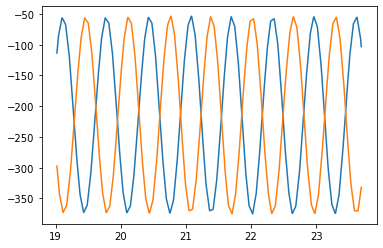

In [145]:
plt.plot(df200Hz['foot_time'], df200Hz['foot_x_pos'])
plt.plot(df200Hz['foot_time'], df200Hz['foot_R_x_pos'])
plt.show()

In [152]:
print(com3d.mean(axis=0))


[ -175.93400801  -272.57287992 -2278.97395586]
